## TUTORIAL 02 - Elastic block problem
**_Keywords: POD-Galerkin method, vector problem_**

### 1. Introduction
In this Tutorial we consider a linear elasticity problem in a two-dimensional square domain $\Omega$.

The domain is partioned in nine square subdomains, as in the following figure

<img src="data/elastic_block.png" width="35%" />

Parameters of this problem include Young moduli of each subdomain, as well as lateral traction on the right side of square. In particular:
* the ratio between the Young modulus of the each subdomain $\Omega_{p+1}$, $p=0,\dots,7$ and the top-right subdomain $\Omega_9$ is denoted by $\mu_p$, being

$$
\mu_p \in \left[1, 100\right] \qquad \text{for }p=0,\dots,7.
$$

* the horizontal tractions on each boundary $\Gamma_{p-6}$, $p=8,\dots,10$, being

$$
\mu_p \in \left[-1,1\right] \qquad \text{for } p=8,\dots, 10.
$$

For what concerns the remaining boundaries, the left boundary $\Gamma_6$ is clamped, while the top and bottom boundaries $\Gamma_1 \cup \Gamma_5$ are traction free.

The parameter vector $\boldsymbol{\mu}$ is thus given by 
$$
\boldsymbol{\mu} = (\mu_0, \cdots,\mu_{10})
$$
on the parameter domain
$$
\mathbb{P}=[1,100]^8\times[-1,1]^3.
$$

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Parametrized formulation

Let $\boldsymbol{u}(\boldsymbol{\mu})$ be the displacement in the domain $\Omega$.

In each subdomain $\Omega_{p+1}$, $p=0,\dots,7$, we assume an isotropic linear elastic material, characterized by the following Lamè constants for plane strain
$$\lambda_1(\mu_p) = \frac{\mu_p \nu}{(1+\nu)(1-2\nu)},$$
$$\lambda_2(\mu_p) = \frac{\mu_p}{2(1+\nu)},$$
for $\nu=0.30$, with the following Piola-Kirchhoff tensor

$$
\boldsymbol{\pi}(\boldsymbol{u}; \mu_p) = 
\lambda_1(\mu_p)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\lambda_2(\mu_p)\;\nabla_{S}\boldsymbol{u}
$$
where $\nabla_{S}$ denotes the symmetric part of the gradient.

Similarly, the Piola-Kirchhoff tensor in the top right subdomain $\Omega_9$ is given by $\boldsymbol{\pi}(\boldsymbol{u}; 1)$.

Thus, the Piola-Kirchhoff tensor on the domain $\Omega$ can be obtained as
$$
\boldsymbol{P}(\boldsymbol{u}; \boldsymbol{\mu}) = 
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\; \boldsymbol{I} +
2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u}
$$
where
$$
\Lambda_1(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_1(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_1(1) \mathbb{1}_{\Omega_{9}}
$$
$$
\Lambda_2(\boldsymbol{\mu}) = \sum_{p=0}^{7} \lambda_2(\mu_p) \mathbb{1}_{\Omega_{p+1}} + \lambda_2(1) \mathbb{1}_{\Omega_{9}}
$$

The strong formulation of the parametrized problem is given by:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $\boldsymbol{u}(\boldsymbol{\mu})$ such that</center>
$$
\begin{cases}
	- \text{div} \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) = 0 & \text{in } \Omega,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{1},\\
	\boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mu_p \mathbf{n} & \text{on } \Gamma_{p-6}, p=8,\dots, 10,\\
    \boldsymbol{P}(\boldsymbol{u}(\boldsymbol{\mu}); \boldsymbol{\mu})) \mathbf{n} = \mathbf{0} & \text{on } \Gamma_{5},\\
	\boldsymbol{u}(\boldsymbol{\mu}) = \boldsymbol{0} & \text{on } \Gamma_{6},\\
\end{cases}
$$
<br>

where $\mathbf{n}$ denotes the outer normal to the boundary $\partial\Omega$.

The corresponding weak formulation reads:
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that</center>

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{\boldsymbol{v}\in H^1(\Omega; \mathbb{R}^2) : \boldsymbol{v}|_{\Gamma_{6}}=\boldsymbol{0}\}
$$
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu})=\int_{\Omega}
\left\{
\Lambda_1(\boldsymbol{\mu})\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\Lambda_2(\boldsymbol{\mu})\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v}
\right\}  d\boldsymbol{x}
$$,
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(\boldsymbol{v}; \boldsymbol{\mu})= \sum_{p=8}^{10} \mu_p \int_{\Gamma_{p-6}} \boldsymbol{v} \cdot \mathbf{n} \ ds$$.

In [1]:
from dolfin import *
from rbnics import *

## 3. Affine decomposition

For this problem the affine decomposition is straightforward. Indeed, owing to the definitions of $\Lambda_1(\boldsymbol{\mu})$ and $\Lambda_2(\boldsymbol{\mu})$, we have:
$$
a(\boldsymbol{u}, \boldsymbol{v}; \boldsymbol{\mu}) = \sum_{p=0}^7 \underbrace{\mu_{\color{red} p}}_{\Theta^{a}_{\color{red} p}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red}{p + 1}}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} p}(\boldsymbol{u}, \boldsymbol{v})} +\\
\underbrace{1}_{\Theta^{a}_{\color{red} 8}(\boldsymbol{\mu})} \underbrace{\int_{\Omega_{\color{red} 9}}
\left\{\lambda_1(1)\;\text{tr}\left[\nabla_{S}\boldsymbol{u}\right]\;\text{tr}\left[\nabla_{S}\boldsymbol{v}\right] + 2\;\lambda_2(1)\;\nabla_{S}\boldsymbol{u} : \nabla_{S}\boldsymbol{v} \right\}  d\boldsymbol{x}}_{a_{\color{red} 8}(\boldsymbol{u}, \boldsymbol{v})}\\
$$
$$
f(\boldsymbol{v}; \boldsymbol{\mu}) = 
\sum_{p=8}^{10} \underbrace{\mu_{\color{red} p}}_{\Theta^{f}_{\color{red}{p-8}}(\boldsymbol{\mu})} \underbrace{\int_{\Gamma_{\color{red}{p-6}}} \boldsymbol{v} \cdot \mathbf{n}}_{f_{\color{red}{p-8}}(\boldsymbol{v})}.
$$

We will implement the numerical discretization of the problem in the class
```
class ElasticBlock(EllipticCoerciveProblem):
```
by specifying the coefficients $\Theta^{a}_*(\boldsymbol{\mu})$ and $\Theta^{f}_*(\boldsymbol{\mu})$ in the method
```
    def compute_theta(self, term):     
```
and the bilinear forms $a_*(\boldsymbol{u}, \boldsymbol{v})$ and linear forms $f_*(\boldsymbol{v})$ in
```
    def assemble_operator(self, term):
```

In [2]:
class ElasticBlock(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # ...
        self.f = Constant((1.0, 0.0))
        self.E = 1.0
        self.nu = 0.3
        self.lambda_1 = self.E * self.nu / ((1.0 + self.nu) * (1.0 - 2.0 * self.nu))
        self.lambda_2 = self.E / (2.0 * (1.0 + self.nu))

    # Return custom problem name
    def name(self):
        return "ElasticBlock"

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[0]
            theta_a1 = mu[1]
            theta_a2 = mu[2]
            theta_a3 = mu[3]
            theta_a4 = mu[4]
            theta_a5 = mu[5]
            theta_a6 = mu[6]
            theta_a7 = mu[7]
            theta_a8 = 1.
            return (theta_a0, theta_a1, theta_a2, theta_a3, theta_a4, theta_a5, theta_a6, theta_a7, theta_a8)
        elif term == "f":
            theta_f0 = mu[8]
            theta_f1 = mu[9]
            theta_f2 = mu[10]
            return (theta_f0, theta_f1, theta_f2)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = self.elasticity(u, v) * dx(1)
            a1 = self.elasticity(u, v) * dx(2)
            a2 = self.elasticity(u, v) * dx(3)
            a3 = self.elasticity(u, v) * dx(4)
            a4 = self.elasticity(u, v) * dx(5)
            a5 = self.elasticity(u, v) * dx(6)
            a6 = self.elasticity(u, v) * dx(7)
            a7 = self.elasticity(u, v) * dx(8)
            a8 = self.elasticity(u, v) * dx(9)
            return (a0, a1, a2, a3, a4, a5, a6, a7, a8)
        elif term == "f":
            ds = self.ds
            f = self.f
            f0 = inner(f, v) * ds(2)
            f1 = inner(f, v) * ds(3)
            f2 = inner(f, v) * ds(4)
            return (f0, f1, f2)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant((0.0, 0.0)), self.boundaries, 6)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(u, v) * dx + inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

    # Auxiliary function to compute the elasticity bilinear form
    def elasticity(self, u, v):
        lambda_1 = self.lambda_1
        lambda_2 = self.lambda_2
        return 2.0 * lambda_2 * inner(sym(grad(u)), sym(grad(v))) + lambda_1 * tr(sym(grad(u))) * tr(sym(grad(v)))

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/elastic_block.xml")
subdomains = MeshFunction("size_t", mesh, "data/elastic_block_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/elastic_block_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = VectorFunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the ElasticBlock class

In [5]:
problem = ElasticBlock(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (1.0, 100.0),
    (-1.0, 1.0),
    (-1.0, 1.0),
    (-1.0, 1.0)
]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(2e-4)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(100)
reduced_problem = reduction_method.offline()

### 4.6. Perform an online solve

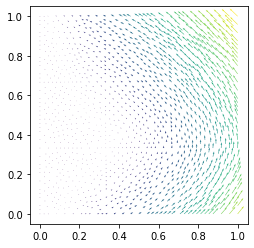

In [8]:
online_mu = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -1.0, -1.0)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
plot(reduced_solution, reduced_problem=reduced_problem)

In [9]:
import inspect
import os

print(os.path.abspath(inspect.getfile(plot)))

/usr/local/lib/python3.6/dist-packages/RBniCS-0.1.dev1-py3.6.egg/rbnics/backends/dolfin/wrapping/plot.py


### 4.7. Perform an error analysis

In [10]:
reduction_method.initialize_testing_set(100)
reduction_method.error_analysis()

=               ElasticBlock POD-Galerkin error analysis begins                =

###################################### 0 #######################################
###################################### 1 #######################################
###################################### 2 #######################################
###################################### 3 #######################################
###################################### 4 #######################################
###################################### 5 #######################################
###################################### 6 #######################################
###################################### 7 #######################################
###################################### 8 #######################################
###################################### 9 #######################################
###################################### 10 ######################################
###########################

###################################### 99 ######################################

N 	gmean(error_u)  	max(error_u)   	gmean(relative_error_u)	max(relative_error_u)
1 	0.03536415989153688	0.20325480655244932	0.22566327112364631    	1.1478526920607148   
2 	0.03142580729209177	0.1417234602318817	0.2005321345957348     	0.9756653342447398   
3 	0.02522604863665798	0.12199653320706684	0.16097067399117684    	0.8621155123563775   
4 	0.021724597801859476	0.08759817905436622	0.1386274640440817     	0.6057620814990073   
5 	0.0162321177720472	0.09052194074054874	0.10357923968613901    	0.6007359193776054   
6 	0.013876534273903158	0.09202220554846088	0.08854795718921543    	0.6061948965182954   
7 	0.010838434978064778	0.08396862439681203	0.06916145324850104    	0.4234030247658649   
8 	0.008811174231444103	0.05229865779547652	0.05622524062798097    	0.3795425175378835   
9 	0.00631101610779791	0.032570269995800184	0.04027140877565483    	0.2859627536488944   
10	0.005912898955509312	0.032473

In [11]:
[reduced_solution_temp, truth_solution_temp] = reduction_method.save_data()

plot(reduced_solution_temp, reduced_problem=reduced_problem)

AttributeError: 'EllipticPODGalerkinReduction' object has no attribute 'save_data'

In [12]:
reduction_method

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.initialize_testing_set(100)
reduction_method.speedup_analysis()

## 5. Assignments
1. Consider now the simplified problem in which 
$$
\mu_0 \equiv \mu_1 \equiv \mu_2 \quad \text{and} \quad \mu_3 \equiv \mu_4 \equiv \mu_5 \quad \text{and} \quad
\mu_6 \equiv \mu_7 = 1 \quad \text{and} \quad \mu_8 \equiv \mu_9 \equiv \mu_{10}
$$
Denote by $\boldsymbol{\eta} = (\mu_0, \mu_3, \mu_8)$ the parameter vector of the simplified problem, defined on the parameter domain $\mathbb{Q}=[1,100]^2\times[-1,1]$.
Implement the simplified problem in a copy of this notebook. What do you observe for what concerns the POD eigenvalue, error analysis, speedup analysis? _Suggestion: for every new notebook copy change the value returned by the name() method of the ElasticBlock class to avoid conflicts between this notebook and your copy_.

2. Create another copy of this notebook, and change the model reduction technique from POD-Galerkin to certified reduced basis. You may need to add a new method in the ElasticBlock class which is currently missing. Compare the results of the error analysis and speedup analysis for the two reduction techniques.
